In [57]:
import math
import csv
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.spatial
import os

from argparse import ArgumentParser
from datetime import datetime
from sklearn.datasets import make_circles, make_moons, make_blobs, make_swiss_roll, make_s_curve
from pyspark import RDD, SparkConf, SparkContext


# See in which connected component s is located.
def findParent(s, connected):
    for indx, l in enumerate(connected):
        if s in l:
            return indx
    
# Kruskals MST algorithm.
# Edges are defined as (v1, v2, weight), where v1 and v2 are the  names of the corresponding vertices
def kruskal(E):
    print("using kruskal on ", len(E), " edges")
    connected = list()
    Selected = list()
    Sorted = sorted(E, key=lambda x: x[2])
    for (s,t,w) in Sorted:
        if findParent(s,connected) is None and findParent(t,connected) is None:
            # we add both,
            connected.append([s,t])
            Selected.append([s,t,w])
        elif findParent(s,connected) is not None and findParent(t,connected) is None:
            # add t to s
            connected[findParent(s,connected)].append(t)
            Selected.append([s,t,w])
        elif findParent(s,connected) is None and findParent(t,connected) is not None:
            # add s to t
            connected[findParent(t,connected)].append(s)
            Selected.append([s,t,w])
        elif findParent(s,connected) is not None and findParent(t,connected) is not None:
            # s and t are in different connected components, so add edge and merge
            if findParent(s,connected) != findParent(t,connected):
                connected[findParent(s,connected)].extend(connected.pop(findParent(t,connected)))
                Selected.append([s,t,w])
    
    return Selected

def computeMST(E):
    print("Doing an itteration with ", len(E), "Edges, with target size: ", target_size)
    if len(E) <= target_size: # remember y = target_size
        return kruskal(E)
    else:
        print("Doesnt fit so spreading....")
        machines = math.ceil(len(E)/target_size)
        RDD = sc.parallelize(E, machines)#.repartition(machines)
        return computeMST( RDD.mapPartitions(lambda a: kruskal(list(a))).collect() )
    
def getConnComp(E, comp):
    connected = [ [i] for i in range(num_points)] # list()
    Sorted = sorted(E, key=lambda x: x[2])[:-(comp-1)]
    for (s,t,w) in Sorted:
        if findParent(s,connected) is None and findParent(t,connected) is None:
            # we add both,
            connected.append([s,t])
        elif findParent(s,connected) is not None and findParent(t,connected) is None:
            # add t to s
            connected[findParent(s,connected)].append(t)
        elif findParent(s,connected) is None and findParent(t,connected) is not None:
            # add s to t
            connected[findParent(t,connected)].append(s)
        elif findParent(s,connected) is not None and findParent(t,connected) is not None:
            # s and t are in different connected components, so add edge and merge
            if findParent(s,connected) != findParent(t,connected):
                connected[findParent(s,connected)].extend(connected.pop(findParent(t,connected)))
    
    return connected

def make_edges(points):
    Edges = []
    for i in range(len(points)):
        for j in range(i+1,len(points)):
            dist = np.sqrt( (points[i][0]-points[j][0])**2 + (points[i][1]-points[j][1])**2  )
            Edges.append([i,j,dist])
    return Edges
        
def getCluster(E, comp):
    comp = getConnComp(E,comp)
    cluster = [0 for i in range(num_points)]
    for idx, cl in enumerate(comp):
        for i in cl:
            cluster[i] = idx
    return cluster

In [13]:
eps = 0.2 # set epsilon
num_points = 500 # How many points do we want

target_size = math.floor(num_points ** (1+eps)) # y = n^(1+eps)

# Some data
noisy_circles = make_circles(n_samples=num_points, factor=.5,
                                 noise=0.05)
noisy_circles = make_moons(n_samples=num_points, noise=0.07)
data = make_blobs(n_samples=num_points, cluster_std=[1.0, 2.5, 0.5])

points = data[0]

# Compute the distance between all points.
Edges = []
for i in range(len(points)):
    for j in range(i+1,len(points)):
        dist = np.sqrt( (points[i][0]-points[j][0])**2 + (points[i][1]-points[j][1])**2  )
        Edges.append([i,j,dist])


conf = SparkConf().setAppName('MST_Algorithm')
sc = SparkContext.getOrCreate(conf=conf)
res = computeMST(Edges)

print(res)

Doing an itteration with  124750 Edges, with target size:  1732
Doesnt fit so spreading....


using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  1024  edges                                     (18 + 2) / 73]
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  2048  edges>                                    (25 + 2) / 73]
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  2048  edge

Doing an itteration with  24660 Edges, with target size:  1732
Doesnt fit so spreading....


using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  1108  edges


Doing an itteration with  5779 Edges, with target size:  1732
Doesnt fit so spreading....
Doing an itteration with  1759 Edges, with target size:  1732
Doesnt fit so spreading....


using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  1683  edges
using kruskal on  879  edges
using kruskal on  880  edges


Doing an itteration with  945 Edges, with target size:  1732
using kruskal on  945  edges
[[322, 415, 0.0031075953492785474], [122, 419, 0.004273139177907171], [89, 156, 0.009103800357809617], [253, 283, 0.0160768381471185], [122, 457, 0.016356902558756253], [54, 285, 0.018254169135011614], [0, 235, 0.018872065789714544], [266, 404, 0.019278825550840165], [287, 347, 0.02051454704212632], [81, 370, 0.023531517860400405], [229, 424, 0.02449932631259503], [89, 314, 0.025716975166427656], [346, 360, 0.02664689806298166], [156, 286, 0.028187074028337873], [267, 308, 0.028966418878773898], [49, 50, 0.029984322486587566], [98, 429, 0.030846280911916022], [162, 268, 0.03132224196871226], [143, 279, 0.03180993520745595], [194, 263, 0.032627165707321375], [184, 340, 0.03310008551761977], [180, 424, 0.0332136099240153], [157, 266, 0.03341341194454408], [24, 363, 0.03472118010513198], [228, 258, 0.035195631286020934], [124, 297, 0.036905547650648275], [383, 385, 0.03784540101667189], [131, 255, 0.

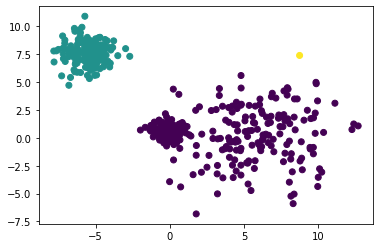

In [14]:
z = getConnComp(res,3)
z[0].sort()
z[1].sort()
#v = [ i in z[0] for i in range(num_points)]
cluster = [0 for i in range(num_points)]
for idx, cl in enumerate(z):
    for i in cl:
        cluster[i] = idx

plt.scatter(points[:,0], points[:,1], c = cluster)

Doing an itteration with  124750 Edges, with target size:  1732
Doesnt fit so spreading....


using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  1024  edges                                     (20 + 2) / 73]
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges===>                

Doing an itteration with  24660 Edges, with target size:  1732
Doesnt fit so spreading....


using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  1108  edges
using kruskal on  2048  edges


Doing an itteration with  5776 Edges, with target size:  1732
Doesnt fit so spreading....
Doing an itteration with  1759 Edges, with target size:  1732
Doesnt fit so spreading....


using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  1680  edges
using kruskal on  880  edges
using kruskal on  879  edges


Doing an itteration with  951 Edges, with target size:  1732
using kruskal on  951  edges
Doing an itteration with  124750 Edges, with target size:  1732
Doesnt fit so spreading....


using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  1024  edges                                     (24 + 2) / 73]
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2

Doing an itteration with  24660 Edges, with target size:  1732
Doesnt fit so spreading....


using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  1108  edges


Doing an itteration with  5781 Edges, with target size:  1732
Doesnt fit so spreading....


using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  1685  edges


Doing an itteration with  1758 Edges, with target size:  1732
Doesnt fit so spreading....
Doing an itteration with  949 Edges, with target size:  1732
using kruskal on  949  edges
Doing an itteration with  124750 Edges, with target size:  1732
Doesnt fit so spreading....


using kruskal on  879  edges
using kruskal on  879  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  1024  edges                                     (24 + 2) / 73]
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  204

Doing an itteration with  24660 Edges, with target size:  1732
Doesnt fit so spreading....


using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  1024using kruskal on  2048  edges
  edges
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  1108  edges
using kruskal on  2048  edges


Doing an itteration with  5778 Edges, with target size:  1732
Doesnt fit so spreading....
Doing an itteration with  1759 Edges, with target size:  1732
Doesnt fit so spreading....


using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  1024  edges
using kruskal on  1682  edges
using kruskal on  880  edges
using kruskal on  879  edges


Doing an itteration with  949 Edges, with target size:  1732
using kruskal on  949  edges
Doing an itteration with  124750 Edges, with target size:  1732
Doesnt fit so spreading....


using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges                                     (19 + 2) / 73]
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on using kruskal on  2048  edges
 2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  2048  edges>                                    (25 + 2) / 73]
using kruskal on  1024  edges
using kruskal on  2048  edge

Doing an itteration with  24660 Edges, with target size:  1732
Doesnt fit so spreading....


using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  1108  edges


Doing an itteration with  5776 Edges, with target size:  1732
Doesnt fit so spreading....
Doing an itteration with  1758 Edges, with target size:  1732
Doesnt fit so spreading....


using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  1680  edges
using kruskal on  1024  edges
using kruskal on  879  edges
using kruskal on  879  edges


Doing an itteration with  949 Edges, with target size:  1732
using kruskal on  949  edges
Doing an itteration with  124750 Edges, with target size:  1732
Doesnt fit so spreading....


using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  2048  edges>                                    (26 + 2) / 73]
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2

Doing an itteration with  24660 Edges, with target size:  1732
Doesnt fit so spreading....


using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  2048  edges
using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  1108  edges
using kruskal on  2048  edges


Doing an itteration with  5781 Edges, with target size:  1732
Doesnt fit so spreading....
Doing an itteration with  1758 Edges, with target size:  1732
Doesnt fit so spreading....


using kruskal on  2048  edges
using kruskal on  1024  edges
using kruskal on  1024  edges
using kruskal on  1685  edges
using kruskal on  879  edges
using kruskal on  879  edges


Doing an itteration with  953 Edges, with target size:  1732
using kruskal on  953  edges


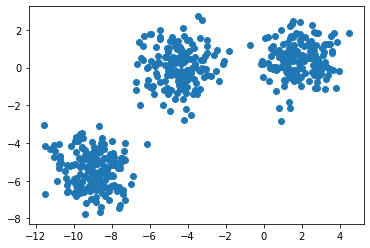

In [77]:
# data = make_blobs(n_samples=num_points, cluster_std=[1.0, 2.5, 0.5])
blobs = make_blobs(n_samples=num_points)
noisy_circles = make_circles(n_samples=num_points, factor=.5,
                                 noise=0.05)
#skewed_blobs = make_blobs(n_samples=num_points, cluster_std=[1.0, 2.5, 0.5])
no_structure = np.random.rand(num_points, 2), None

random_state = 170
X, y = make_blobs(n_samples=num_points, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)


datasets = [blobs, noisy_circles, skewed_blobs, aniso ,no_structure ]
Edges = [make_edges(x[0]) for x in datasets]
MSTs = [computeMST(e) for e in Edges]

points = data[0]
points = X
plt.scatter(points[:,0], points[:,1])

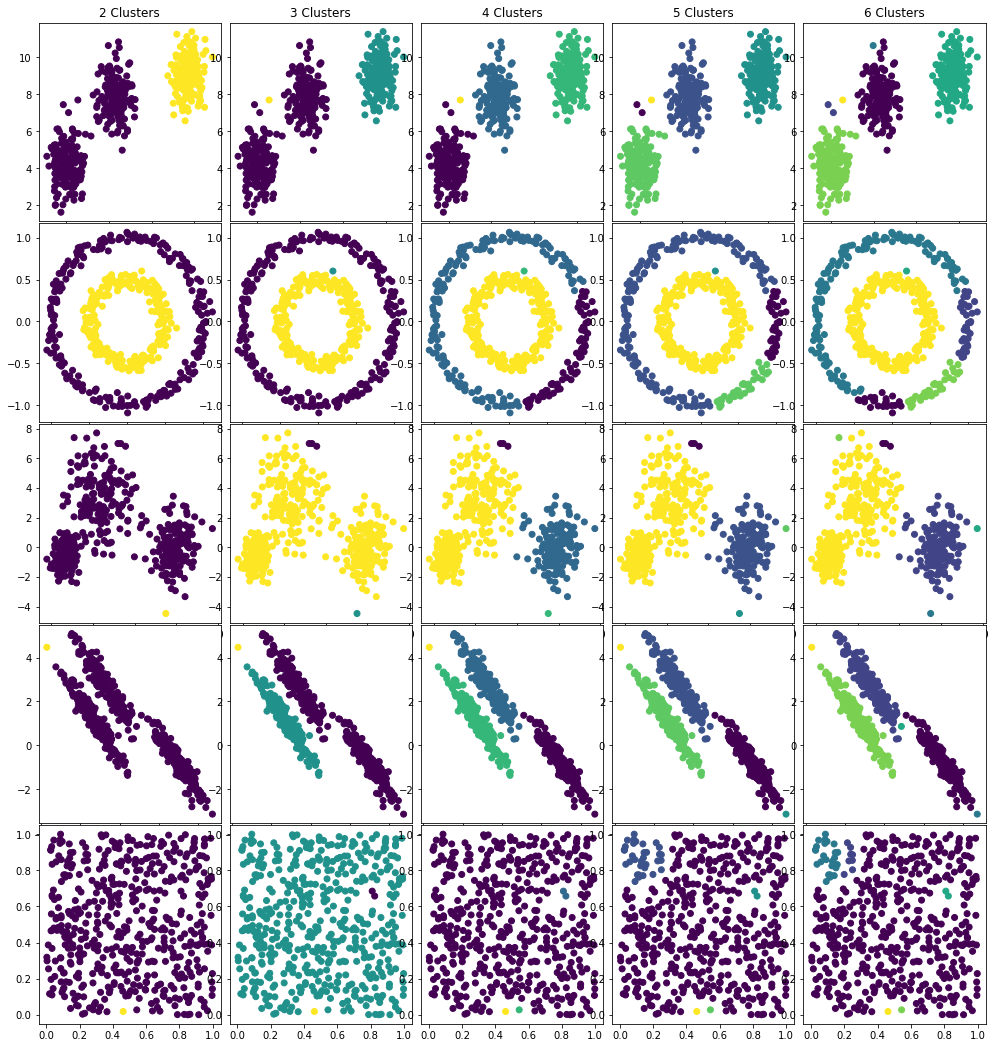

In [95]:
depth = list(range(5))
plt.figure(figsize=(9 * 1.3 + 2, 14.5))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.05, hspace=0.01
)


for idx, MST in enumerate(MSTs):
    for d in depth:
        cluster = getCluster(MST,d+2)
        p = datasets[idx][0]
        plt.subplot(len(depth),len(MSTs), idx*len(depth)+d+1)
        plt.scatter(p[:,0],p[:,1], c=cluster)
        if idx == 0:
            plt.title(str(d+2)+" Clusters")

In [56]:
getCluster(MSTs[0],3)

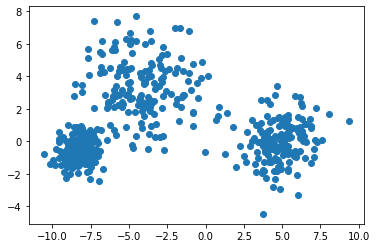

In [76]:
skewed_blobs = make_blobs(n_samples=num_points, cluster_std=[1.25, 2.0, 0.75])
points = skewed_blobs[0]
plt.scatter(points[:,0], points[:,1])

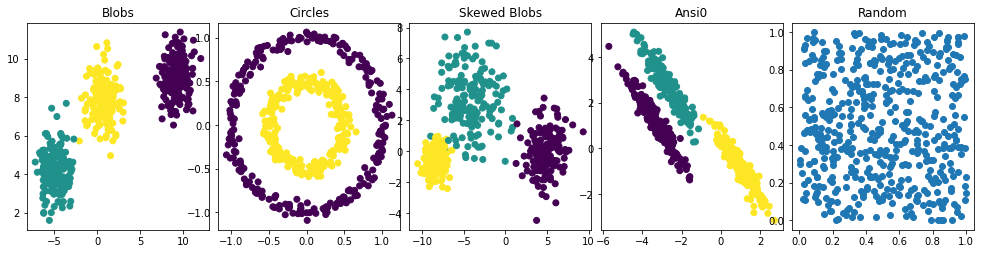

In [97]:
plt.figure(figsize=(9 * 1.3 + 2, 3))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.05, hspace=0.01
)
names = ["Blobs","Circles", "Skewed Blobs", "Ansi0", "Random"]
for idx, name in enumerate(names):
    plt.subplot(1,5, idx+1)
    p = datasets[idx][0]
    cl = datasets[idx][1]
    plt.scatter(p[:,0],p[:,1], c = cl)
    plt.title(names[idx])



In [84]:
p

(array([[ 1.38959003e-01,  8.11254173e+00],
        [-4.36554620e+00,  4.87991849e+00],
        [ 8.94212355e-01,  7.96573568e+00],
        [ 7.94599909e+00,  1.12516688e+01],
        [ 9.91176675e+00,  9.27781149e+00],
        [ 8.78335179e+00,  9.26990443e+00],
        [-4.03396599e+00,  4.84221619e+00],
        [ 1.12423680e+01,  1.09680080e+01],
        [-6.17157210e+00,  5.14122112e+00],
        [ 1.68999270e+00,  6.28770992e+00],
        [ 1.21920716e+00,  1.05301341e+01],
        [-5.56841609e+00,  4.57437226e+00],
        [-5.04080596e+00,  3.34578158e+00],
        [-2.84481252e+00,  4.63076405e+00],
        [-4.82492514e+00,  3.81035685e+00],
        [-6.31559482e+00,  3.70173094e+00],
        [ 8.54686185e+00,  8.64361582e+00],
        [ 1.07307797e+01,  8.19396573e+00],
        [ 3.03665432e-01,  9.27525914e+00],
        [ 9.44265045e+00,  7.76414729e+00],
        [-5.78871817e-02,  7.92217211e+00],
        [ 7.90849264e+00,  9.99663797e+00],
        [ 9.40815450e+00,  1.025